<a href="https://colab.research.google.com/github/aseemdandgaval/GalleryGAN/blob/master/GalleryGAN_(500).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GalleryGAN: Generating abstract art images from scratch with GANs** 

Generative Adversarial Networks or GANs , are used for Generative modeling. Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

* In this Project, I will use GANs to **generate completely new images** from scratch of Abstract images, by training the two neural networks on the Abstract Art Gallery  Dataset.

## **Importing the neccesary Libraries**

In [ ]:
# Importing the neccesary libraries

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

C:\Users\aseem\anaconda3\envs\dl\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [ ]:
!pip install opendatasets --upgrade --quiet

import os
import torch
import tarfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import opendatasets as od
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms as tt

from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import Image
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## **Downloading and Checking the Dataset**

* I have used the [Abstract Art Gallery](https://www.kaggle.com/muhammad4hmed/gan-aa/data) dataset which consists of 2800 images of abstract images.


In [ ]:
# Downloading the dataset from kaggle using the opendatasets library.

dataset_url = 'https://www.kaggle.com/bryanb/abstract-art-gallery'
od.download(dataset_url)

Skipping, found downloaded files in ".\abstract-art-gallery" (use force=True to force download)


In [ ]:
# Checking the dataset

data_dir = './abstract-art-gallery/Abstract_gallery'

print(os.listdir(data_dir +'/Abstract_gallery')[:10])

['Abstract_image_0.jpg', 'Abstract_image_1.jpg', 'Abstract_image_10.jpg', 'Abstract_image_100.jpg', 'Abstract_image_1000.jpg', 'Abstract_image_1001.jpg', 'Abstract_image_1002.jpg', 'Abstract_image_1003.jpg', 'Abstract_image_1004.jpg', 'Abstract_image_1005.jpg']


### **Data Augmentation and Regularization**

* In **data augmentation**, the dataset is augmented or transformed, i.e resized, cropped, warped, stretched, rotated, flipped etc. This is done so that in every epoch, a slightly different version of the same image is passed to the neural networks, **artificially increasing the size of the dataset** and **prevent overfitting** by forcing the neural network to make a generalized model.


* **Regularizations** like normalization is used to ensure that all values being fed to the network are in a certain range, so that **no value disproportionately affects the model and results**.


* These techniques are key to avoid overfitting and training a good model.


In [ ]:
# Setting parameters to create the Dataset and DataLoaders

image_size = 512
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
# Applying data augmentation/ transforms and creating DataLoaders

train_ds = ImageFolder(data_dir, transform=T.Compose([
                        T.RandomHorizontalFlip(p=0.5),
                        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        T.RandomResizedCrop(image_size, scale=(0.5,0.9), ratio=(1, 1)), 
                        #T.Resize(image_size),
                        #T.CenterCrop(image_size),
                        T.ToTensor(),
                        T.Normalize(*stats)]))

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

In [ ]:
# Denormalize the data to view the images with proper colours

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
# Creating functions for showing the images in a batch

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

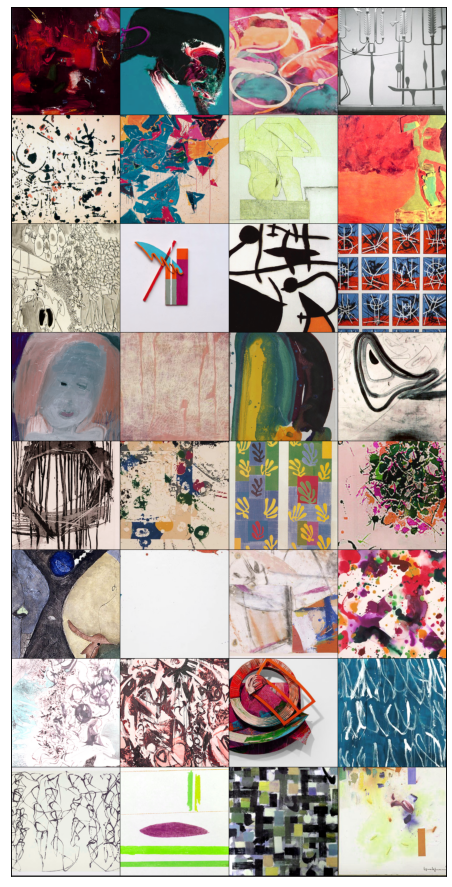

In [ ]:
show_batch(train_dl)

## **Using a GPU**

In [ ]:
# Helper functions to tranfer Tensors and DataLoaders to the GPU for faster training

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## **Discriminator Network**

* The discriminator takes an image as input, and tries to classify it as "**real**" or "**generated**".
* In this sense, it's like any other neural network.
* For example the closer the output after activations is to one, the more likely it is to be real and vice versa.
* The classification will be **binary** - Real or Generated.
* We'll use a convolutional neural networks (CNN) which outputs a single number output for every image.
* We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

* The above animation is for a convolution with stride=2 and padding=1.

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 512 x 512

    nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 8 x 256 x 256

    nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16 x 128 x 128

    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

![image](https://user-images.githubusercontent.com/79587733/149306230-281a1cde-155b-49cf-9a49-2bb9ac9d4dbe.png)

In [ ]:
 discriminator = to_device(discriminator, device)

In [ ]:
# Checking the discriminator model

for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = discriminator(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([32, 3, 512, 512])
out.shape: torch.Size([32, 1])


## **Generator Network**

* The input to the generator is typically a vector or a matrix of random numbers or a **latent tensor** which is used as a seed for generating an image.
* The generator will convert a latent tensor of shape `(256, 1, 1)` into an image tensor of shape `3 x 512 x 512`, each different random vector would give a different image. 
* The idea is to change the weights as to create an image that looks like the real image, in this case, an abstract image.
* If you noticed, we're converting a random latent tensor/vector to a 3 channel image, this is the **opposite of convolution**.
* To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a **transposed convolution** (also referred to as a **deconvolution**).

![](https://i.imgur.com/DRvK546.gif)

* The above is the animation for a transposed convolution.

In [ ]:
latent_size = 256

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 128 x 128

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # out: 16 x 256 x 256

    nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 512 x 512
)


![image](https://user-images.githubusercontent.com/79587733/149307300-e0de0a35-077b-43d3-9b93-0b9d13404735.png)

torch.Size([32, 3, 512, 512])


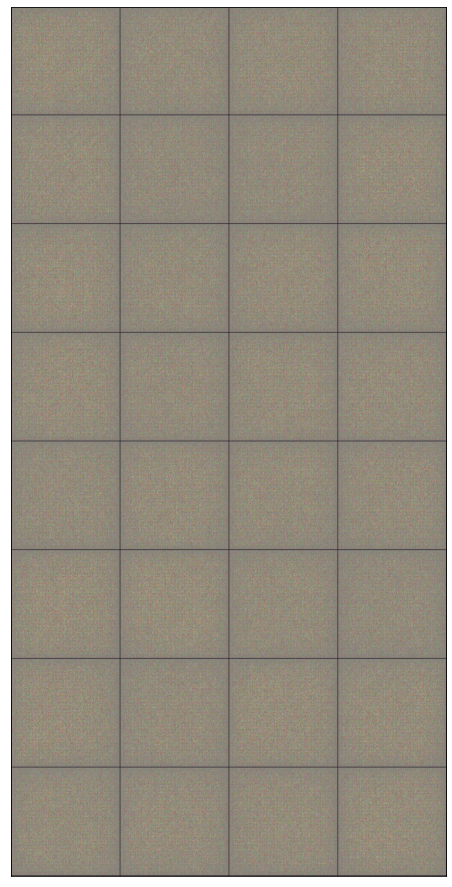

In [ ]:
# Checking the generator model

xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors

fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

## **Training the Discriminator**

* Since the discriminator is a binary classification model, we can use the **binary cross entropy loss function** to quantify how well it is able to differentiate between real and generated images.



* Here are the steps involved in training the discriminator.

    * We expect the discriminator to output 1 if the image was picked from the real dataset, and 0 if it was generated using the generator network. 

    * We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

    * Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

    * Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

* It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()


    ### Pass real images through discriminator
        # The images are taken from the dataset and passed through the discriminator and we get the predictions
    real_preds = discriminator(real_images) 
        # We set all the target labels as 1. Because all the images are REAL.
    real_targets = torch.ones(real_images.size(0), 1, device=device) 
        # With the targets and predictions, we calulate the loss like all the other models.
    real_loss = F.binary_cross_entropy(real_preds, real_targets) 
        # We then take the mean of all the predictions made by the discriminator on real images.
        # We want this mean to be closer to one, this means that the discriminator is really good at detecting real images.
    real_score = torch.mean(real_preds).item() 
    

    ### Generate fake images
        # We also need to pass a batch of fake image to the discriminator, so that it knows which images should be classified as fake.
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    ### Pass fake images through discriminator
        # The targets to the fake images are obviously set to 0 becasuse they are FAKE.
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
        # Then we calculate the predictions on the fake images by passing a batch of them to the discriminator.
    fake_preds = discriminator(fake_images)
        # With the targets and predictions, we calulate the loss.
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        # We take the mean of all the predictions made by the discriminator on fake images.
        # We want this mean to be closer to zero, this means that the discriminator is really good at detecting fake images.
    fake_score = torch.mean(fake_preds).item()

    ### Update discriminator weights
        # The overall loss is the combined loss calculated by the discriminator on the real and fake images.
        # The gradients are then calculated using the .backward() function.
        # Then gradient decent will be applied and the weights will be changed.
        # We return real_score, fake_score as the evaluation metrics.
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## **Training the Generator**



* Since the outputs of the generator are images, it's not obvious how we can train the generator.
*  This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function.
* Here's how it works:

    * We generate a batch of images using the generator, pass the into the discriminator.

    * We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

    * We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.


In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    ### Try to fool the discriminator
        # Pass the generated fake images to the discriminator and get predictions.
        # The targets are set as 1, that is REAL.
        # If the discriminator is predicting the values closer to 1, that means that the generated fake images are being classified as REAL.
        # In other words, the discriminator is being fooled.
        # We then calculate the loss to perform gradient descent to change the weights of the generator.
        # So that it progressively become better at generating real-like images to fool the discriminator.
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

**Helper functions to ssave the images**

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=4).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


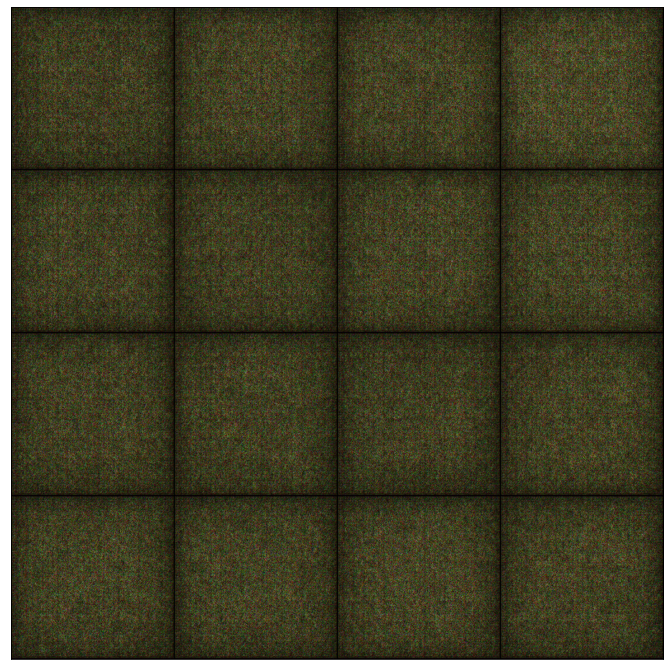

In [ ]:
save_samples(0, fixed_latent)

## **Full Training Loop**

In [ ]:
def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

### **Training the Model**

In [ ]:
discriminator

Sequential(
  (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Bat

In [ ]:
generator

Sequential(
  (0): ConvTranspose2d(256, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
lr_d = 0.0005
lr_g = 0.001
epochs = 500

In [ ]:
history = fit(epochs, lr_d, lr_g)

  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [1/500], loss_g: 1.7885, loss_d: 0.9676, real_score: 0.7378, fake_score: 0.4702
Saving generated-images-0001.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [2/500], loss_g: 4.0005, loss_d: 0.1723, real_score: 0.9437, fake_score: 0.1067
Saving generated-images-0002.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [3/500], loss_g: 5.1980, loss_d: 0.0534, real_score: 0.9863, fake_score: 0.0386
Saving generated-images-0003.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [4/500], loss_g: 6.3580, loss_d: 0.0327, real_score: 0.9718, fake_score: 0.0040
Saving generated-images-0004.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [5/500], loss_g: 4.6388, loss_d: 0.0555, real_score: 0.9608, fake_score: 0.0149
Saving generated-images-0005.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [6/500], loss_g: 7.0063, loss_d: 0.3410, real_score: 0.9730, fake_score: 0.2422
Saving generated-images-0006.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [7/500], loss_g: 3.2879, loss_d: 0.3702, real_score: 0.8256, fake_score: 0.1552
Saving generated-images-0007.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [8/500], loss_g: 0.5642, loss_d: 0.7840, real_score: 0.6179, fake_score: 0.2116
Saving generated-images-0008.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [9/500], loss_g: 3.4391, loss_d: 0.1669, real_score: 0.9086, fake_score: 0.0655
Saving generated-images-0009.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [10/500], loss_g: 7.6993, loss_d: 0.3278, real_score: 0.9613, fake_score: 0.2399
Saving generated-images-0010.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [11/500], loss_g: 7.0512, loss_d: 0.6539, real_score: 0.9333, fake_score: 0.4327
Saving generated-images-0011.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [12/500], loss_g: 2.8816, loss_d: 0.6261, real_score: 0.7509, fake_score: 0.2540
Saving generated-images-0012.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [13/500], loss_g: 5.3583, loss_d: 0.0745, real_score: 0.9582, fake_score: 0.0294
Saving generated-images-0013.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [14/500], loss_g: 3.5161, loss_d: 0.5496, real_score: 0.9391, fake_score: 0.3750
Saving generated-images-0014.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [15/500], loss_g: 1.7932, loss_d: 0.7143, real_score: 0.9010, fake_score: 0.4359
Saving generated-images-0015.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [16/500], loss_g: 2.9340, loss_d: 0.6676, real_score: 0.5708, fake_score: 0.0341
Saving generated-images-0016.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [17/500], loss_g: 2.0538, loss_d: 0.8737, real_score: 0.5105, fake_score: 0.1497
Saving generated-images-0017.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [18/500], loss_g: 3.9920, loss_d: 0.8631, real_score: 0.7644, fake_score: 0.3977
Saving generated-images-0018.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [19/500], loss_g: 1.7684, loss_d: 0.5101, real_score: 0.7639, fake_score: 0.1872
Saving generated-images-0019.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [20/500], loss_g: 3.4321, loss_d: 0.5626, real_score: 0.7809, fake_score: 0.2414
Saving generated-images-0020.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [21/500], loss_g: 3.5009, loss_d: 0.5079, real_score: 0.9545, fake_score: 0.3633
Saving generated-images-0021.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [22/500], loss_g: 10.3907, loss_d: 0.3533, real_score: 0.7207, fake_score: 0.0001
Saving generated-images-0022.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [23/500], loss_g: 1.8578, loss_d: 0.4770, real_score: 0.8875, fake_score: 0.2802
Saving generated-images-0023.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [24/500], loss_g: 3.9254, loss_d: 0.3528, real_score: 0.7243, fake_score: 0.0105
Saving generated-images-0024.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [25/500], loss_g: 6.7531, loss_d: 0.0362, real_score: 0.9685, fake_score: 0.0036
Saving generated-images-0025.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [26/500], loss_g: 5.5196, loss_d: 0.0411, real_score: 0.9710, fake_score: 0.0114
Saving generated-images-0026.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [27/500], loss_g: 8.5218, loss_d: 0.7531, real_score: 0.5171, fake_score: 0.0017
Saving generated-images-0027.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [28/500], loss_g: 4.8427, loss_d: 0.0988, real_score: 0.9274, fake_score: 0.0192
Saving generated-images-0028.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [29/500], loss_g: 5.4037, loss_d: 0.1586, real_score: 0.9041, fake_score: 0.0527
Saving generated-images-0029.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [30/500], loss_g: 1.9365, loss_d: 1.2736, real_score: 0.3444, fake_score: 0.0516
Saving generated-images-0030.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [31/500], loss_g: 4.1247, loss_d: 0.2795, real_score: 0.7850, fake_score: 0.0201
Saving generated-images-0031.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [32/500], loss_g: 3.9161, loss_d: 0.0831, real_score: 0.9468, fake_score: 0.0273
Saving generated-images-0032.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [33/500], loss_g: 9.4529, loss_d: 0.3903, real_score: 0.7021, fake_score: 0.0002
Saving generated-images-0033.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [34/500], loss_g: 6.4786, loss_d: 0.4700, real_score: 0.9435, fake_score: 0.3134
Saving generated-images-0034.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [35/500], loss_g: 5.2495, loss_d: 0.3009, real_score: 0.7900, fake_score: 0.0506
Saving generated-images-0035.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [36/500], loss_g: 2.5686, loss_d: 0.3629, real_score: 0.8272, fake_score: 0.1331
Saving generated-images-0036.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [37/500], loss_g: 5.0249, loss_d: 0.3895, real_score: 0.7049, fake_score: 0.0121
Saving generated-images-0037.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [38/500], loss_g: 5.4211, loss_d: 0.1271, real_score: 0.9067, fake_score: 0.0260
Saving generated-images-0038.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [39/500], loss_g: 3.2598, loss_d: 0.0825, real_score: 0.9671, fake_score: 0.0467
Saving generated-images-0039.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [40/500], loss_g: 6.2652, loss_d: 1.2062, real_score: 0.3318, fake_score: 0.0083
Saving generated-images-0040.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [41/500], loss_g: 8.3755, loss_d: 0.1271, real_score: 0.8835, fake_score: 0.0002
Saving generated-images-0041.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [42/500], loss_g: 5.5202, loss_d: 0.1751, real_score: 0.9521, fake_score: 0.1146
Saving generated-images-0042.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [43/500], loss_g: 4.4043, loss_d: 0.8071, real_score: 0.9908, fake_score: 0.4662
Saving generated-images-0043.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [44/500], loss_g: 5.0509, loss_d: 0.7377, real_score: 0.5503, fake_score: 0.0025
Saving generated-images-0044.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [45/500], loss_g: 2.9080, loss_d: 0.6379, real_score: 0.5790, fake_score: 0.0065
Saving generated-images-0045.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [46/500], loss_g: 3.1738, loss_d: 1.3309, real_score: 0.8567, fake_score: 0.6302
Saving generated-images-0046.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [47/500], loss_g: 4.0444, loss_d: 0.1216, real_score: 0.9591, fake_score: 0.0746
Saving generated-images-0047.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [48/500], loss_g: 2.5389, loss_d: 0.5628, real_score: 0.9888, fake_score: 0.3932
Saving generated-images-0048.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [49/500], loss_g: 4.0688, loss_d: 0.8708, real_score: 0.9870, fake_score: 0.5218
Saving generated-images-0049.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [50/500], loss_g: 2.6370, loss_d: 0.6583, real_score: 0.9608, fake_score: 0.3929
Saving generated-images-0050.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [51/500], loss_g: 4.9605, loss_d: 0.1887, real_score: 0.9936, fake_score: 0.1552
Saving generated-images-0051.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [52/500], loss_g: 2.9909, loss_d: 0.2095, real_score: 0.8290, fake_score: 0.0092
Saving generated-images-0052.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [53/500], loss_g: 2.6206, loss_d: 0.2581, real_score: 0.9799, fake_score: 0.1991
Saving generated-images-0053.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [54/500], loss_g: 7.8321, loss_d: 0.5355, real_score: 0.6401, fake_score: 0.0001
Saving generated-images-0054.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [55/500], loss_g: 8.6814, loss_d: 0.4702, real_score: 0.7155, fake_score: 0.0027
Saving generated-images-0055.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [56/500], loss_g: 5.0264, loss_d: 0.0436, real_score: 0.9693, fake_score: 0.0116
Saving generated-images-0056.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [57/500], loss_g: 1.4087, loss_d: 0.1783, real_score: 0.9816, fake_score: 0.1339
Saving generated-images-0057.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [58/500], loss_g: 2.1748, loss_d: 0.4272, real_score: 0.7357, fake_score: 0.0660
Saving generated-images-0058.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [59/500], loss_g: 3.1071, loss_d: 0.2150, real_score: 0.8595, fake_score: 0.0491
Saving generated-images-0059.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [60/500], loss_g: 9.5835, loss_d: 1.1649, real_score: 0.9495, fake_score: 0.6191
Saving generated-images-0060.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [61/500], loss_g: 3.7911, loss_d: 0.2708, real_score: 0.9102, fake_score: 0.1513
Saving generated-images-0061.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [62/500], loss_g: 4.3992, loss_d: 2.1553, real_score: 0.1734, fake_score: 0.0319
Saving generated-images-0062.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [63/500], loss_g: 1.9511, loss_d: 0.2466, real_score: 0.8355, fake_score: 0.0108
Saving generated-images-0063.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [64/500], loss_g: 6.0345, loss_d: 0.0539, real_score: 0.9735, fake_score: 0.0256
Saving generated-images-0064.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [65/500], loss_g: 5.6650, loss_d: 0.0581, real_score: 0.9718, fake_score: 0.0281
Saving generated-images-0065.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [66/500], loss_g: 4.2065, loss_d: 0.0470, real_score: 0.9858, fake_score: 0.0318
Saving generated-images-0066.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [67/500], loss_g: 4.2759, loss_d: 0.4080, real_score: 0.8781, fake_score: 0.2036
Saving generated-images-0067.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [68/500], loss_g: 5.7719, loss_d: 0.0143, real_score: 0.9967, fake_score: 0.0109
Saving generated-images-0068.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [69/500], loss_g: 2.8703, loss_d: 0.1643, real_score: 0.8957, fake_score: 0.0475
Saving generated-images-0069.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [70/500], loss_g: 4.5010, loss_d: 0.1978, real_score: 0.9985, fake_score: 0.1666
Saving generated-images-0070.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [71/500], loss_g: 5.7362, loss_d: 1.0721, real_score: 0.6652, fake_score: 0.4268
Saving generated-images-0071.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [72/500], loss_g: 5.9624, loss_d: 0.3066, real_score: 0.7817, fake_score: 0.0154
Saving generated-images-0072.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [73/500], loss_g: 2.6139, loss_d: 0.2018, real_score: 0.8578, fake_score: 0.0135
Saving generated-images-0073.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [74/500], loss_g: 7.2179, loss_d: 0.1314, real_score: 0.8876, fake_score: 0.0019
Saving generated-images-0074.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [75/500], loss_g: 3.5926, loss_d: 0.7006, real_score: 0.7583, fake_score: 0.2857
Saving generated-images-0075.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [76/500], loss_g: 7.8818, loss_d: 0.2725, real_score: 0.9970, fake_score: 0.2128
Saving generated-images-0076.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [77/500], loss_g: 1.8571, loss_d: 0.4874, real_score: 0.6808, fake_score: 0.0683
Saving generated-images-0077.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [78/500], loss_g: 4.1261, loss_d: 0.1881, real_score: 0.9606, fake_score: 0.1271
Saving generated-images-0078.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [79/500], loss_g: 2.1026, loss_d: 0.0191, real_score: 0.9982, fake_score: 0.0168
Saving generated-images-0079.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [80/500], loss_g: 8.1577, loss_d: 0.0770, real_score: 0.9353, fake_score: 0.0004
Saving generated-images-0080.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [81/500], loss_g: 4.4280, loss_d: 0.0444, real_score: 0.9706, fake_score: 0.0137
Saving generated-images-0081.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [82/500], loss_g: 8.1029, loss_d: 0.1546, real_score: 0.8644, fake_score: 0.0001
Saving generated-images-0082.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [83/500], loss_g: 6.7974, loss_d: 0.0271, real_score: 0.9748, fake_score: 0.0010
Saving generated-images-0083.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [84/500], loss_g: 9.6440, loss_d: 1.1774, real_score: 0.9588, fake_score: 0.6271
Saving generated-images-0084.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [85/500], loss_g: 1.5686, loss_d: 0.0225, real_score: 0.9893, fake_score: 0.0115
Saving generated-images-0085.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [86/500], loss_g: 3.0032, loss_d: 0.6769, real_score: 0.9937, fake_score: 0.4182
Saving generated-images-0086.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [87/500], loss_g: 5.8617, loss_d: 0.4937, real_score: 0.6610, fake_score: 0.0003
Saving generated-images-0087.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [88/500], loss_g: 3.2373, loss_d: 0.5021, real_score: 0.7639, fake_score: 0.1256
Saving generated-images-0088.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [89/500], loss_g: 2.7849, loss_d: 0.1527, real_score: 0.8968, fake_score: 0.0216
Saving generated-images-0089.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [90/500], loss_g: 6.3775, loss_d: 0.1501, real_score: 0.8689, fake_score: 0.0019
Saving generated-images-0090.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [91/500], loss_g: 4.3791, loss_d: 0.0302, real_score: 0.9881, fake_score: 0.0178
Saving generated-images-0091.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [92/500], loss_g: 3.6296, loss_d: 0.6300, real_score: 0.5872, fake_score: 0.0037
Saving generated-images-0092.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [93/500], loss_g: 0.9347, loss_d: 0.4782, real_score: 0.7591, fake_score: 0.1379
Saving generated-images-0093.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [94/500], loss_g: 1.9361, loss_d: 0.0820, real_score: 0.9499, fake_score: 0.0270
Saving generated-images-0094.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [95/500], loss_g: 5.0669, loss_d: 0.1868, real_score: 0.9979, fake_score: 0.1406
Saving generated-images-0095.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [96/500], loss_g: 3.0266, loss_d: 0.2447, real_score: 0.8277, fake_score: 0.0204
Saving generated-images-0096.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [97/500], loss_g: 4.6476, loss_d: 0.7179, real_score: 0.5652, fake_score: 0.0120
Saving generated-images-0097.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [98/500], loss_g: 5.5769, loss_d: 0.5420, real_score: 0.6538, fake_score: 0.0392
Saving generated-images-0098.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [99/500], loss_g: 3.8271, loss_d: 0.1674, real_score: 0.9546, fake_score: 0.1054
Saving generated-images-0099.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [100/500], loss_g: 5.4958, loss_d: 0.7982, real_score: 0.9610, fake_score: 0.4634
Saving generated-images-0100.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [101/500], loss_g: 5.1397, loss_d: 0.2017, real_score: 0.8325, fake_score: 0.0016
Saving generated-images-0101.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [102/500], loss_g: 4.1123, loss_d: 0.1226, real_score: 0.8903, fake_score: 0.0021
Saving generated-images-0102.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [103/500], loss_g: 5.2328, loss_d: 0.1902, real_score: 0.8806, fake_score: 0.0404
Saving generated-images-0103.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [104/500], loss_g: 5.6573, loss_d: 0.5624, real_score: 0.9667, fake_score: 0.3812
Saving generated-images-0104.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [105/500], loss_g: 8.3934, loss_d: 0.6086, real_score: 0.9878, fake_score: 0.4107
Saving generated-images-0105.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [106/500], loss_g: 0.6598, loss_d: 0.6564, real_score: 0.6777, fake_score: 0.1777
Saving generated-images-0106.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [107/500], loss_g: 3.6806, loss_d: 0.3675, real_score: 0.7217, fake_score: 0.0046
Saving generated-images-0107.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [108/500], loss_g: 5.8319, loss_d: 0.1320, real_score: 0.8867, fake_score: 0.0037
Saving generated-images-0108.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [109/500], loss_g: 5.9513, loss_d: 1.0875, real_score: 0.4040, fake_score: 0.0012
Saving generated-images-0109.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [110/500], loss_g: 5.5482, loss_d: 0.0431, real_score: 0.9665, fake_score: 0.0084
Saving generated-images-0110.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [111/500], loss_g: 4.7129, loss_d: 0.1454, real_score: 0.9330, fake_score: 0.0664
Saving generated-images-0111.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [112/500], loss_g: 4.4120, loss_d: 0.9162, real_score: 0.8826, fake_score: 0.5088
Saving generated-images-0112.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [113/500], loss_g: 4.8668, loss_d: 0.1693, real_score: 0.8950, fake_score: 0.0367
Saving generated-images-0113.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [114/500], loss_g: 3.3511, loss_d: 0.5240, real_score: 0.7387, fake_score: 0.1401
Saving generated-images-0114.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [115/500], loss_g: 5.3832, loss_d: 0.3623, real_score: 0.9226, fake_score: 0.2264
Saving generated-images-0115.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [116/500], loss_g: 3.9403, loss_d: 0.3005, real_score: 0.8795, fake_score: 0.1381
Saving generated-images-0116.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [117/500], loss_g: 0.7712, loss_d: 0.1405, real_score: 0.9704, fake_score: 0.0995
Saving generated-images-0117.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [118/500], loss_g: 1.2529, loss_d: 1.2769, real_score: 0.3764, fake_score: 0.0699
Saving generated-images-0118.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [119/500], loss_g: 2.4332, loss_d: 0.8888, real_score: 0.4695, fake_score: 0.0344
Saving generated-images-0119.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [120/500], loss_g: 4.3102, loss_d: 0.0146, real_score: 0.9907, fake_score: 0.0051
Saving generated-images-0120.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [121/500], loss_g: 8.4127, loss_d: 0.1039, real_score: 0.9059, fake_score: 0.0006
Saving generated-images-0121.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [122/500], loss_g: 0.1435, loss_d: 0.7553, real_score: 0.5188, fake_score: 0.0143
Saving generated-images-0122.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [123/500], loss_g: 2.8293, loss_d: 1.0060, real_score: 0.4628, fake_score: 0.0072
Saving generated-images-0123.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [124/500], loss_g: 3.6667, loss_d: 0.0311, real_score: 0.9906, fake_score: 0.0211
Saving generated-images-0124.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [125/500], loss_g: 3.4888, loss_d: 1.1431, real_score: 0.9545, fake_score: 0.6128
Saving generated-images-0125.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [126/500], loss_g: 7.0734, loss_d: 2.6491, real_score: 0.9909, fake_score: 0.8747
Saving generated-images-0126.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [127/500], loss_g: 2.6082, loss_d: 0.0821, real_score: 0.9585, fake_score: 0.0363
Saving generated-images-0127.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [128/500], loss_g: 5.6094, loss_d: 0.1123, real_score: 0.9321, fake_score: 0.0371
Saving generated-images-0128.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [129/500], loss_g: 3.4776, loss_d: 0.0964, real_score: 0.9910, fake_score: 0.0814
Saving generated-images-0129.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [130/500], loss_g: 4.0319, loss_d: 0.0808, real_score: 0.9380, fake_score: 0.0150
Saving generated-images-0130.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [131/500], loss_g: 6.4497, loss_d: 0.9429, real_score: 0.9702, fake_score: 0.5383
Saving generated-images-0131.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [132/500], loss_g: 1.6647, loss_d: 0.1805, real_score: 0.9042, fake_score: 0.0681
Saving generated-images-0132.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [133/500], loss_g: 5.6294, loss_d: 1.1449, real_score: 0.9848, fake_score: 0.6222
Saving generated-images-0133.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [134/500], loss_g: 5.8201, loss_d: 1.1753, real_score: 0.9957, fake_score: 0.6261
Saving generated-images-0134.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [135/500], loss_g: 2.4879, loss_d: 1.3124, real_score: 0.3625, fake_score: 0.0069
Saving generated-images-0135.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [136/500], loss_g: 1.2484, loss_d: 0.6779, real_score: 0.5706, fake_score: 0.0437
Saving generated-images-0136.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [137/500], loss_g: 6.4054, loss_d: 0.0823, real_score: 0.9311, fake_score: 0.0008
Saving generated-images-0137.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [138/500], loss_g: 2.9560, loss_d: 0.3697, real_score: 0.7859, fake_score: 0.0727
Saving generated-images-0138.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [139/500], loss_g: 5.4341, loss_d: 1.2847, real_score: 0.3486, fake_score: 0.0278
Saving generated-images-0139.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [140/500], loss_g: 0.7712, loss_d: 3.5186, real_score: 0.0486, fake_score: 0.0482
Saving generated-images-0140.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [141/500], loss_g: 2.1470, loss_d: 0.2633, real_score: 0.7927, fake_score: 0.0118
Saving generated-images-0141.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [142/500], loss_g: 1.5136, loss_d: 0.6498, real_score: 0.6459, fake_score: 0.1425
Saving generated-images-0142.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [143/500], loss_g: 3.0849, loss_d: 0.3364, real_score: 0.9683, fake_score: 0.2517
Saving generated-images-0143.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [144/500], loss_g: 1.8332, loss_d: 0.9753, real_score: 0.4537, fake_score: 0.0299
Saving generated-images-0144.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [145/500], loss_g: 3.5007, loss_d: 0.3622, real_score: 0.7247, fake_score: 0.0068
Saving generated-images-0145.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [146/500], loss_g: 4.3851, loss_d: 0.6442, real_score: 0.9831, fake_score: 0.4075
Saving generated-images-0146.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [147/500], loss_g: 3.9873, loss_d: 0.5929, real_score: 0.6567, fake_score: 0.0631
Saving generated-images-0147.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [148/500], loss_g: 1.8813, loss_d: 1.3979, real_score: 0.4954, fake_score: 0.4049
Saving generated-images-0148.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [149/500], loss_g: 5.3392, loss_d: 1.1240, real_score: 0.9493, fake_score: 0.5610
Saving generated-images-0149.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [150/500], loss_g: 3.8146, loss_d: 0.2397, real_score: 0.9456, fake_score: 0.1357
Saving generated-images-0150.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [151/500], loss_g: 2.4679, loss_d: 0.5596, real_score: 0.6906, fake_score: 0.0990
Saving generated-images-0151.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [152/500], loss_g: 3.5337, loss_d: 0.4801, real_score: 0.8064, fake_score: 0.1925
Saving generated-images-0152.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [153/500], loss_g: 2.8338, loss_d: 0.4914, real_score: 0.6617, fake_score: 0.0068
Saving generated-images-0153.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [154/500], loss_g: 4.1204, loss_d: 0.5723, real_score: 0.6203, fake_score: 0.0351
Saving generated-images-0154.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [155/500], loss_g: 2.8273, loss_d: 0.1503, real_score: 0.9499, fake_score: 0.0871
Saving generated-images-0155.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [156/500], loss_g: 5.7446, loss_d: 0.3961, real_score: 0.7063, fake_score: 0.0060
Saving generated-images-0156.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [157/500], loss_g: 2.3191, loss_d: 1.6196, real_score: 0.2675, fake_score: 0.0080
Saving generated-images-0157.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [158/500], loss_g: 5.5601, loss_d: 0.1206, real_score: 0.9650, fake_score: 0.0787
Saving generated-images-0158.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [159/500], loss_g: 3.4204, loss_d: 0.6824, real_score: 0.8433, fake_score: 0.3286
Saving generated-images-0159.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [160/500], loss_g: 1.5578, loss_d: 0.6506, real_score: 0.5837, fake_score: 0.0309
Saving generated-images-0160.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [161/500], loss_g: 5.5899, loss_d: 0.0980, real_score: 0.9215, fake_score: 0.0044
Saving generated-images-0161.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [162/500], loss_g: 6.8147, loss_d: 1.1840, real_score: 0.9618, fake_score: 0.6223
Saving generated-images-0162.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [163/500], loss_g: 3.2003, loss_d: 0.4244, real_score: 0.7694, fake_score: 0.1169
Saving generated-images-0163.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [164/500], loss_g: 4.0619, loss_d: 0.8376, real_score: 0.5067, fake_score: 0.0019
Saving generated-images-0164.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [165/500], loss_g: 5.2206, loss_d: 0.7194, real_score: 0.5653, fake_score: 0.0222
Saving generated-images-0165.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [166/500], loss_g: 2.8126, loss_d: 0.0727, real_score: 0.9777, fake_score: 0.0468
Saving generated-images-0166.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [167/500], loss_g: 5.2425, loss_d: 0.4962, real_score: 0.7414, fake_score: 0.1150
Saving generated-images-0167.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [168/500], loss_g: 8.1518, loss_d: 1.0929, real_score: 0.9604, fake_score: 0.5858
Saving generated-images-0168.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [169/500], loss_g: 6.3490, loss_d: 0.0865, real_score: 0.9377, fake_score: 0.0197
Saving generated-images-0169.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [170/500], loss_g: 5.1600, loss_d: 0.4187, real_score: 0.6907, fake_score: 0.0007
Saving generated-images-0170.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [171/500], loss_g: 6.6125, loss_d: 0.6610, real_score: 0.6124, fake_score: 0.0029
Saving generated-images-0171.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [172/500], loss_g: 7.3867, loss_d: 0.8840, real_score: 0.9964, fake_score: 0.4871
Saving generated-images-0172.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [173/500], loss_g: 3.8588, loss_d: 0.2017, real_score: 0.8552, fake_score: 0.0162
Saving generated-images-0173.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [174/500], loss_g: 3.6598, loss_d: 0.2611, real_score: 0.8070, fake_score: 0.0218
Saving generated-images-0174.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [175/500], loss_g: 3.0630, loss_d: 0.0659, real_score: 0.9822, fake_score: 0.0454
Saving generated-images-0175.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [176/500], loss_g: 4.9654, loss_d: 0.1291, real_score: 0.9036, fake_score: 0.0174
Saving generated-images-0176.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [177/500], loss_g: 1.8797, loss_d: 0.5201, real_score: 0.7026, fake_score: 0.0489
Saving generated-images-0177.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [178/500], loss_g: 8.9726, loss_d: 0.0467, real_score: 0.9578, fake_score: 0.0008
Saving generated-images-0178.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [179/500], loss_g: 5.1512, loss_d: 0.2222, real_score: 0.8987, fake_score: 0.0793
Saving generated-images-0179.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [180/500], loss_g: 4.3218, loss_d: 0.3295, real_score: 0.7763, fake_score: 0.0167
Saving generated-images-0180.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [181/500], loss_g: 6.5968, loss_d: 1.0975, real_score: 0.4166, fake_score: 0.0018
Saving generated-images-0181.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [182/500], loss_g: 1.3299, loss_d: 1.0432, real_score: 0.5948, fake_score: 0.2060
Saving generated-images-0182.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [183/500], loss_g: 4.0536, loss_d: 0.1382, real_score: 0.9302, fake_score: 0.0553
Saving generated-images-0183.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [184/500], loss_g: 10.3063, loss_d: 0.1062, real_score: 0.9334, fake_score: 0.0238
Saving generated-images-0184.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [185/500], loss_g: 1.8560, loss_d: 0.1403, real_score: 0.9277, fake_score: 0.0512
Saving generated-images-0185.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [186/500], loss_g: 4.9174, loss_d: 0.2803, real_score: 0.9589, fake_score: 0.1774
Saving generated-images-0186.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [187/500], loss_g: 4.4368, loss_d: 0.1560, real_score: 0.8951, fake_score: 0.0230
Saving generated-images-0187.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [188/500], loss_g: 3.2273, loss_d: 0.2457, real_score: 0.8444, fake_score: 0.0394
Saving generated-images-0188.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [189/500], loss_g: 6.0684, loss_d: 0.8774, real_score: 0.9121, fake_score: 0.4501
Saving generated-images-0189.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [190/500], loss_g: 2.6626, loss_d: 0.5349, real_score: 0.7051, fake_score: 0.0961
Saving generated-images-0190.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [191/500], loss_g: 7.0288, loss_d: 0.2230, real_score: 0.8438, fake_score: 0.0149
Saving generated-images-0191.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [192/500], loss_g: 1.8697, loss_d: 0.4565, real_score: 0.9853, fake_score: 0.2979
Saving generated-images-0192.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [193/500], loss_g: 6.7953, loss_d: 0.1033, real_score: 0.9419, fake_score: 0.0311
Saving generated-images-0193.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [194/500], loss_g: 11.7277, loss_d: 0.1336, real_score: 0.9498, fake_score: 0.0028
Saving generated-images-0194.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [195/500], loss_g: 8.1138, loss_d: 0.1390, real_score: 0.9218, fake_score: 0.0444
Saving generated-images-0195.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [196/500], loss_g: 2.2567, loss_d: 0.0675, real_score: 0.9604, fake_score: 0.0246
Saving generated-images-0196.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [197/500], loss_g: 6.1319, loss_d: 0.1752, real_score: 0.8603, fake_score: 0.0044
Saving generated-images-0197.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [198/500], loss_g: 2.3853, loss_d: 0.0650, real_score: 0.9630, fake_score: 0.0220
Saving generated-images-0198.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [199/500], loss_g: 3.2709, loss_d: 0.1212, real_score: 0.9978, fake_score: 0.1033
Saving generated-images-0199.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [200/500], loss_g: 7.0086, loss_d: 0.1666, real_score: 0.8781, fake_score: 0.0055
Saving generated-images-0200.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [201/500], loss_g: 11.0087, loss_d: 0.1069, real_score: 0.9093, fake_score: 0.0039
Saving generated-images-0201.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [202/500], loss_g: 4.5929, loss_d: 0.2063, real_score: 0.8338, fake_score: 0.0052
Saving generated-images-0202.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [203/500], loss_g: 4.2545, loss_d: 0.1343, real_score: 0.9921, fake_score: 0.1139
Saving generated-images-0203.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [204/500], loss_g: 7.3493, loss_d: 0.0806, real_score: 0.9324, fake_score: 0.0069
Saving generated-images-0204.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [205/500], loss_g: 3.9566, loss_d: 0.3801, real_score: 0.7635, fake_score: 0.0631
Saving generated-images-0205.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [206/500], loss_g: 4.9921, loss_d: 0.5752, real_score: 0.8372, fake_score: 0.2353
Saving generated-images-0206.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [207/500], loss_g: 0.7586, loss_d: 1.0709, real_score: 0.4535, fake_score: 0.0045
Saving generated-images-0207.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [208/500], loss_g: 5.6464, loss_d: 1.3018, real_score: 0.9535, fake_score: 0.4171
Saving generated-images-0208.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [209/500], loss_g: 4.8290, loss_d: 0.2201, real_score: 0.9901, fake_score: 0.1521
Saving generated-images-0209.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [210/500], loss_g: 5.1388, loss_d: 0.0923, real_score: 0.9538, fake_score: 0.0291
Saving generated-images-0210.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [211/500], loss_g: 3.9062, loss_d: 0.0960, real_score: 0.9791, fake_score: 0.0674
Saving generated-images-0211.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [212/500], loss_g: 6.1748, loss_d: 0.3580, real_score: 0.9925, fake_score: 0.2649
Saving generated-images-0212.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [213/500], loss_g: 6.0113, loss_d: 1.0802, real_score: 0.7107, fake_score: 0.3226
Saving generated-images-0213.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [214/500], loss_g: 2.0700, loss_d: 0.3264, real_score: 0.7964, fake_score: 0.0323
Saving generated-images-0214.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [215/500], loss_g: 4.3839, loss_d: 0.4569, real_score: 0.9715, fake_score: 0.3034
Saving generated-images-0215.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [216/500], loss_g: 1.5894, loss_d: 1.5920, real_score: 0.3354, fake_score: 0.0004
Saving generated-images-0216.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [217/500], loss_g: 6.7276, loss_d: 0.1494, real_score: 0.9478, fake_score: 0.0783
Saving generated-images-0217.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [218/500], loss_g: 5.5178, loss_d: 1.3960, real_score: 0.3507, fake_score: 0.0003
Saving generated-images-0218.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [219/500], loss_g: 6.0453, loss_d: 0.9778, real_score: 0.4872, fake_score: 0.0032
Saving generated-images-0219.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [220/500], loss_g: 5.2131, loss_d: 0.5503, real_score: 0.6544, fake_score: 0.0021
Saving generated-images-0220.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [221/500], loss_g: 5.7400, loss_d: 0.4158, real_score: 0.8046, fake_score: 0.1313
Saving generated-images-0221.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [222/500], loss_g: 5.3421, loss_d: 0.2485, real_score: 0.9619, fake_score: 0.1737
Saving generated-images-0222.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [223/500], loss_g: 9.7926, loss_d: 0.5272, real_score: 0.6862, fake_score: 0.0003
Saving generated-images-0223.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [224/500], loss_g: 3.0182, loss_d: 1.4991, real_score: 0.3053, fake_score: 0.0081
Saving generated-images-0224.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [225/500], loss_g: 5.6985, loss_d: 0.4169, real_score: 0.7159, fake_score: 0.0063
Saving generated-images-0225.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [226/500], loss_g: 2.9930, loss_d: 0.6638, real_score: 0.6422, fake_score: 0.0066
Saving generated-images-0226.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [227/500], loss_g: 4.8840, loss_d: 0.2747, real_score: 0.9374, fake_score: 0.1408
Saving generated-images-0227.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [228/500], loss_g: 3.4450, loss_d: 0.2553, real_score: 0.9499, fake_score: 0.1570
Saving generated-images-0228.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [229/500], loss_g: 3.9051, loss_d: 0.0221, real_score: 0.9881, fake_score: 0.0096
Saving generated-images-0229.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [230/500], loss_g: 5.9629, loss_d: 0.3163, real_score: 0.9955, fake_score: 0.2206
Saving generated-images-0230.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [231/500], loss_g: 1.5497, loss_d: 0.1489, real_score: 0.9513, fake_score: 0.0824
Saving generated-images-0231.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [232/500], loss_g: 9.2608, loss_d: 1.4447, real_score: 0.9461, fake_score: 0.6431
Saving generated-images-0232.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [233/500], loss_g: 9.1440, loss_d: 0.0153, real_score: 0.9897, fake_score: 0.0048
Saving generated-images-0233.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [234/500], loss_g: 8.1348, loss_d: 0.0489, real_score: 0.9798, fake_score: 0.0245
Saving generated-images-0234.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [235/500], loss_g: 2.2817, loss_d: 0.3053, real_score: 0.8188, fake_score: 0.0538
Saving generated-images-0235.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [236/500], loss_g: 5.2649, loss_d: 0.1180, real_score: 0.9374, fake_score: 0.0386
Saving generated-images-0236.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [237/500], loss_g: 4.0180, loss_d: 0.4124, real_score: 0.8639, fake_score: 0.1617
Saving generated-images-0237.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [238/500], loss_g: 5.0911, loss_d: 0.1865, real_score: 0.8729, fake_score: 0.0285
Saving generated-images-0238.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [239/500], loss_g: 2.8494, loss_d: 0.1553, real_score: 0.9308, fake_score: 0.0761
Saving generated-images-0239.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [240/500], loss_g: 8.5753, loss_d: 0.0197, real_score: 0.9926, fake_score: 0.0119
Saving generated-images-0240.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [241/500], loss_g: 5.4312, loss_d: 0.0300, real_score: 0.9763, fake_score: 0.0055
Saving generated-images-0241.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [242/500], loss_g: 6.6416, loss_d: 0.3532, real_score: 0.8486, fake_score: 0.1292
Saving generated-images-0242.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [243/500], loss_g: 4.3504, loss_d: 0.5017, real_score: 0.7026, fake_score: 0.0022
Saving generated-images-0243.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [244/500], loss_g: 3.3021, loss_d: 0.1587, real_score: 0.9846, fake_score: 0.1008
Saving generated-images-0244.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [245/500], loss_g: 2.7486, loss_d: 0.3136, real_score: 0.8224, fake_score: 0.0610
Saving generated-images-0245.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [246/500], loss_g: 5.9627, loss_d: 0.1501, real_score: 0.8906, fake_score: 0.0128
Saving generated-images-0246.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [247/500], loss_g: 5.4607, loss_d: 0.1617, real_score: 0.8943, fake_score: 0.0361
Saving generated-images-0247.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [248/500], loss_g: 2.9007, loss_d: 0.1086, real_score: 0.9808, fake_score: 0.0785
Saving generated-images-0248.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [249/500], loss_g: 6.2731, loss_d: 0.1757, real_score: 0.9759, fake_score: 0.1126
Saving generated-images-0249.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [250/500], loss_g: 4.6003, loss_d: 0.1497, real_score: 0.9789, fake_score: 0.1037
Saving generated-images-0250.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [251/500], loss_g: 4.1002, loss_d: 0.4383, real_score: 0.9870, fake_score: 0.3005
Saving generated-images-0251.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [252/500], loss_g: 8.4318, loss_d: 0.1652, real_score: 0.8687, fake_score: 0.0052
Saving generated-images-0252.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [253/500], loss_g: 1.6921, loss_d: 0.6678, real_score: 0.6393, fake_score: 0.0081
Saving generated-images-0253.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [254/500], loss_g: 6.6342, loss_d: 0.0814, real_score: 0.9837, fake_score: 0.0585
Saving generated-images-0254.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [255/500], loss_g: 5.3230, loss_d: 0.2516, real_score: 0.9254, fake_score: 0.1208
Saving generated-images-0255.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [256/500], loss_g: 6.6665, loss_d: 0.0209, real_score: 0.9815, fake_score: 0.0020
Saving generated-images-0256.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [257/500], loss_g: 4.1087, loss_d: 0.3448, real_score: 0.8967, fake_score: 0.1445
Saving generated-images-0257.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [258/500], loss_g: 7.9476, loss_d: 0.9190, real_score: 0.9411, fake_score: 0.4786
Saving generated-images-0258.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [259/500], loss_g: 3.3487, loss_d: 0.3049, real_score: 0.7859, fake_score: 0.0082
Saving generated-images-0259.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [260/500], loss_g: 2.8935, loss_d: 0.1476, real_score: 0.9781, fake_score: 0.1070
Saving generated-images-0260.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [261/500], loss_g: 4.8826, loss_d: 0.0699, real_score: 0.9475, fake_score: 0.0071
Saving generated-images-0261.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [262/500], loss_g: 7.0404, loss_d: 0.0418, real_score: 0.9843, fake_score: 0.0234
Saving generated-images-0262.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [263/500], loss_g: 6.9530, loss_d: 0.1420, real_score: 0.9145, fake_score: 0.0143
Saving generated-images-0263.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [264/500], loss_g: 8.9119, loss_d: 0.8137, real_score: 0.9565, fake_score: 0.3857
Saving generated-images-0264.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [265/500], loss_g: 5.5648, loss_d: 0.2228, real_score: 0.9929, fake_score: 0.1663
Saving generated-images-0265.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [266/500], loss_g: 3.9584, loss_d: 0.0804, real_score: 0.9729, fake_score: 0.0471
Saving generated-images-0266.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [267/500], loss_g: 10.6738, loss_d: 0.0298, real_score: 0.9712, fake_score: 0.0002
Saving generated-images-0267.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [268/500], loss_g: 4.4423, loss_d: 0.0712, real_score: 0.9396, fake_score: 0.0028
Saving generated-images-0268.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [269/500], loss_g: 0.6056, loss_d: 1.8624, real_score: 0.2891, fake_score: 0.0033
Saving generated-images-0269.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [270/500], loss_g: 8.5236, loss_d: 0.4239, real_score: 0.9971, fake_score: 0.2388
Saving generated-images-0270.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [271/500], loss_g: 5.6470, loss_d: 0.2919, real_score: 0.9365, fake_score: 0.1569
Saving generated-images-0271.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [272/500], loss_g: 3.6236, loss_d: 0.2762, real_score: 0.9117, fake_score: 0.1211
Saving generated-images-0272.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [273/500], loss_g: 8.4715, loss_d: 0.2294, real_score: 0.9957, fake_score: 0.1791
Saving generated-images-0273.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [274/500], loss_g: 5.2013, loss_d: 0.0877, real_score: 0.9794, fake_score: 0.0597
Saving generated-images-0274.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [275/500], loss_g: 5.3203, loss_d: 0.2212, real_score: 0.8223, fake_score: 0.0005
Saving generated-images-0275.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [276/500], loss_g: 5.5944, loss_d: 0.0865, real_score: 0.9283, fake_score: 0.0015
Saving generated-images-0276.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [277/500], loss_g: 7.5580, loss_d: 0.1083, real_score: 0.9298, fake_score: 0.0259
Saving generated-images-0277.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [278/500], loss_g: 7.3877, loss_d: 0.0294, real_score: 0.9877, fake_score: 0.0163
Saving generated-images-0278.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [279/500], loss_g: 7.6494, loss_d: 0.0227, real_score: 0.9998, fake_score: 0.0206
Saving generated-images-0279.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [280/500], loss_g: 8.9471, loss_d: 0.0671, real_score: 0.9435, fake_score: 0.0017
Saving generated-images-0280.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [281/500], loss_g: 5.3561, loss_d: 0.0408, real_score: 0.9727, fake_score: 0.0106
Saving generated-images-0281.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [282/500], loss_g: 5.1629, loss_d: 0.1139, real_score: 0.9479, fake_score: 0.0462
Saving generated-images-0282.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [283/500], loss_g: 7.7542, loss_d: 0.0944, real_score: 0.9176, fake_score: 0.0016
Saving generated-images-0283.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [284/500], loss_g: 7.2840, loss_d: 0.0445, real_score: 0.9970, fake_score: 0.0395
Saving generated-images-0284.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [285/500], loss_g: 10.6860, loss_d: 0.1067, real_score: 0.9125, fake_score: 0.0005
Saving generated-images-0285.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [286/500], loss_g: 5.5296, loss_d: 0.0868, real_score: 0.9323, fake_score: 0.0088
Saving generated-images-0286.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [287/500], loss_g: 6.5056, loss_d: 0.2143, real_score: 0.9446, fake_score: 0.0862
Saving generated-images-0287.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [288/500], loss_g: 1.8833, loss_d: 0.0164, real_score: 1.0000, fake_score: 0.0158
Saving generated-images-0288.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [289/500], loss_g: 11.5779, loss_d: 0.7250, real_score: 0.9874, fake_score: 0.4121
Saving generated-images-0289.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [290/500], loss_g: 3.1264, loss_d: 0.1562, real_score: 0.9472, fake_score: 0.0787
Saving generated-images-0290.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [291/500], loss_g: 4.0816, loss_d: 0.1608, real_score: 0.9251, fake_score: 0.0560
Saving generated-images-0291.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [292/500], loss_g: 4.8901, loss_d: 0.1972, real_score: 0.9998, fake_score: 0.1574
Saving generated-images-0292.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [293/500], loss_g: 6.7171, loss_d: 0.0528, real_score: 0.9911, fake_score: 0.0409
Saving generated-images-0293.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [294/500], loss_g: 7.2122, loss_d: 0.4461, real_score: 0.7165, fake_score: 0.0032
Saving generated-images-0294.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [295/500], loss_g: 6.1145, loss_d: 0.3440, real_score: 0.8840, fake_score: 0.1493
Saving generated-images-0295.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [296/500], loss_g: 6.9373, loss_d: 0.0552, real_score: 0.9613, fake_score: 0.0047
Saving generated-images-0296.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [297/500], loss_g: 10.1196, loss_d: 0.1465, real_score: 0.8978, fake_score: 0.0021
Saving generated-images-0297.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [298/500], loss_g: 6.6476, loss_d: 0.2305, real_score: 0.9535, fake_score: 0.0210
Saving generated-images-0298.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [299/500], loss_g: 10.1757, loss_d: 0.2092, real_score: 0.9962, fake_score: 0.1274
Saving generated-images-0299.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [300/500], loss_g: 16.7560, loss_d: 1.6615, real_score: 0.9851, fake_score: 0.7091
Saving generated-images-0300.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [301/500], loss_g: 8.0704, loss_d: 0.0528, real_score: 0.9516, fake_score: 0.0003
Saving generated-images-0301.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [302/500], loss_g: 3.8309, loss_d: 0.0555, real_score: 0.9538, fake_score: 0.0014
Saving generated-images-0302.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [303/500], loss_g: 10.1145, loss_d: 2.0333, real_score: 0.2805, fake_score: 0.0000
Saving generated-images-0303.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [304/500], loss_g: 6.5792, loss_d: 0.1527, real_score: 0.8880, fake_score: 0.0177
Saving generated-images-0304.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [305/500], loss_g: 7.4778, loss_d: 0.0228, real_score: 0.9879, fake_score: 0.0101
Saving generated-images-0305.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [306/500], loss_g: 7.4132, loss_d: 0.2155, real_score: 0.9595, fake_score: 0.1344
Saving generated-images-0306.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [307/500], loss_g: 4.0431, loss_d: 0.1628, real_score: 0.9958, fake_score: 0.0775
Saving generated-images-0307.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [308/500], loss_g: 9.1723, loss_d: 0.0913, real_score: 0.9351, fake_score: 0.0003
Saving generated-images-0308.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [309/500], loss_g: 8.9506, loss_d: 0.0538, real_score: 0.9642, fake_score: 0.0120
Saving generated-images-0309.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [310/500], loss_g: 5.5537, loss_d: 0.0586, real_score: 0.9516, fake_score: 0.0068
Saving generated-images-0310.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [311/500], loss_g: 6.4826, loss_d: 0.1177, real_score: 0.9039, fake_score: 0.0019
Saving generated-images-0311.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [312/500], loss_g: 4.9213, loss_d: 0.1947, real_score: 0.9306, fake_score: 0.0768
Saving generated-images-0312.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [313/500], loss_g: 7.7359, loss_d: 0.0509, real_score: 0.9538, fake_score: 0.0017
Saving generated-images-0313.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [314/500], loss_g: 4.7710, loss_d: 0.0439, real_score: 0.9846, fake_score: 0.0263
Saving generated-images-0314.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [315/500], loss_g: 5.1924, loss_d: 0.0313, real_score: 0.9780, fake_score: 0.0078
Saving generated-images-0315.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [316/500], loss_g: 5.6677, loss_d: 0.1073, real_score: 0.9105, fake_score: 0.0013
Saving generated-images-0316.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [317/500], loss_g: 6.0986, loss_d: 0.0734, real_score: 0.9961, fake_score: 0.0539
Saving generated-images-0317.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [318/500], loss_g: 10.1340, loss_d: 0.4196, real_score: 0.9914, fake_score: 0.2564
Saving generated-images-0318.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [319/500], loss_g: 6.0058, loss_d: 0.0737, real_score: 0.9544, fake_score: 0.0225
Saving generated-images-0319.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [320/500], loss_g: 5.1798, loss_d: 0.0464, real_score: 0.9698, fake_score: 0.0113
Saving generated-images-0320.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [321/500], loss_g: 7.9856, loss_d: 0.1754, real_score: 0.8805, fake_score: 0.0009
Saving generated-images-0321.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [322/500], loss_g: 5.9501, loss_d: 0.0813, real_score: 0.9937, fake_score: 0.0607
Saving generated-images-0322.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [323/500], loss_g: 4.4455, loss_d: 0.0713, real_score: 0.9588, fake_score: 0.0173
Saving generated-images-0323.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [324/500], loss_g: 6.2254, loss_d: 0.0309, real_score: 0.9951, fake_score: 0.0246
Saving generated-images-0324.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [325/500], loss_g: 3.8371, loss_d: 0.1114, real_score: 0.9625, fake_score: 0.0576
Saving generated-images-0325.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [326/500], loss_g: 5.5312, loss_d: 0.0757, real_score: 0.9990, fake_score: 0.0604
Saving generated-images-0326.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [327/500], loss_g: 2.5101, loss_d: 0.5133, real_score: 0.6618, fake_score: 0.0025
Saving generated-images-0327.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [328/500], loss_g: 6.7790, loss_d: 0.9248, real_score: 0.5818, fake_score: 0.0031
Saving generated-images-0328.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [329/500], loss_g: 7.0830, loss_d: 0.0559, real_score: 0.9555, fake_score: 0.0023
Saving generated-images-0329.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [330/500], loss_g: 3.2139, loss_d: 0.1543, real_score: 0.8847, fake_score: 0.0178
Saving generated-images-0330.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [331/500], loss_g: 6.3089, loss_d: 0.2747, real_score: 0.9785, fake_score: 0.1930
Saving generated-images-0331.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [332/500], loss_g: 4.1272, loss_d: 0.1396, real_score: 0.9298, fake_score: 0.0304
Saving generated-images-0332.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [333/500], loss_g: 10.8009, loss_d: 0.2417, real_score: 0.9850, fake_score: 0.1666
Saving generated-images-0333.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [334/500], loss_g: 5.0080, loss_d: 0.1036, real_score: 0.9251, fake_score: 0.0115
Saving generated-images-0334.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [335/500], loss_g: 11.6552, loss_d: 0.9800, real_score: 0.9907, fake_score: 0.5041
Saving generated-images-0335.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [336/500], loss_g: 7.4997, loss_d: 0.2095, real_score: 0.8395, fake_score: 0.0003
Saving generated-images-0336.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [337/500], loss_g: 6.8373, loss_d: 0.1563, real_score: 0.9788, fake_score: 0.1175
Saving generated-images-0337.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [338/500], loss_g: 5.7905, loss_d: 0.1083, real_score: 0.9132, fake_score: 0.0049
Saving generated-images-0338.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [339/500], loss_g: 5.6602, loss_d: 0.1367, real_score: 0.8904, fake_score: 0.0063
Saving generated-images-0339.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [340/500], loss_g: 3.1858, loss_d: 0.4638, real_score: 0.7422, fake_score: 0.0197
Saving generated-images-0340.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [341/500], loss_g: 4.0885, loss_d: 0.0271, real_score: 0.9990, fake_score: 0.0250
Saving generated-images-0341.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [342/500], loss_g: 6.1314, loss_d: 0.1023, real_score: 0.9631, fake_score: 0.0559
Saving generated-images-0342.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [343/500], loss_g: 1.3855, loss_d: 0.9891, real_score: 0.5293, fake_score: 0.0178
Saving generated-images-0343.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [344/500], loss_g: 9.8989, loss_d: 0.0661, real_score: 0.9645, fake_score: 0.0176
Saving generated-images-0344.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [345/500], loss_g: 4.4210, loss_d: 0.1152, real_score: 0.9900, fake_score: 0.0869
Saving generated-images-0345.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [346/500], loss_g: 13.9148, loss_d: 0.5723, real_score: 0.6413, fake_score: 0.0000
Saving generated-images-0346.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [347/500], loss_g: 9.0288, loss_d: 0.2660, real_score: 0.9961, fake_score: 0.1837
Saving generated-images-0347.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [348/500], loss_g: 9.2639, loss_d: 0.0591, real_score: 0.9545, fake_score: 0.0009
Saving generated-images-0348.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [349/500], loss_g: 6.9836, loss_d: 0.1566, real_score: 0.9637, fake_score: 0.0943
Saving generated-images-0349.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [350/500], loss_g: 9.0657, loss_d: 0.3445, real_score: 0.9999, fake_score: 0.2488
Saving generated-images-0350.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [351/500], loss_g: 7.2645, loss_d: 0.0132, real_score: 0.9956, fake_score: 0.0086
Saving generated-images-0351.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [352/500], loss_g: 8.6566, loss_d: 0.0506, real_score: 0.9966, fake_score: 0.0448
Saving generated-images-0352.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [353/500], loss_g: 7.7282, loss_d: 0.2680, real_score: 0.8199, fake_score: 0.0006
Saving generated-images-0353.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [354/500], loss_g: 7.7313, loss_d: 0.0059, real_score: 0.9946, fake_score: 0.0004
Saving generated-images-0354.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [355/500], loss_g: 6.6237, loss_d: 0.0600, real_score: 0.9861, fake_score: 0.0414
Saving generated-images-0355.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [356/500], loss_g: 3.6132, loss_d: 0.1630, real_score: 0.9585, fake_score: 0.0585
Saving generated-images-0356.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [357/500], loss_g: 5.3608, loss_d: 0.0322, real_score: 0.9862, fake_score: 0.0167
Saving generated-images-0357.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [358/500], loss_g: 7.7169, loss_d: 0.0645, real_score: 0.9526, fake_score: 0.0125
Saving generated-images-0358.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [359/500], loss_g: 7.3195, loss_d: 0.4318, real_score: 0.9792, fake_score: 0.2770
Saving generated-images-0359.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [360/500], loss_g: 6.7676, loss_d: 0.1343, real_score: 0.9965, fake_score: 0.1046
Saving generated-images-0360.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [361/500], loss_g: 3.9481, loss_d: 0.3310, real_score: 0.8005, fake_score: 0.0070
Saving generated-images-0361.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [362/500], loss_g: 9.8359, loss_d: 0.5111, real_score: 0.9998, fake_score: 0.3002
Saving generated-images-0362.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [363/500], loss_g: 6.2724, loss_d: 0.3479, real_score: 0.9914, fake_score: 0.2317
Saving generated-images-0363.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [364/500], loss_g: 5.5602, loss_d: 0.1121, real_score: 0.9246, fake_score: 0.0021
Saving generated-images-0364.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [365/500], loss_g: 5.6168, loss_d: 0.1228, real_score: 0.9974, fake_score: 0.0824
Saving generated-images-0365.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [366/500], loss_g: 6.0313, loss_d: 0.0115, real_score: 0.9996, fake_score: 0.0109
Saving generated-images-0366.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [367/500], loss_g: 7.8082, loss_d: 0.1700, real_score: 0.9021, fake_score: 0.0429
Saving generated-images-0367.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [368/500], loss_g: 3.4643, loss_d: 0.0024, real_score: 0.9997, fake_score: 0.0021
Saving generated-images-0368.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [369/500], loss_g: 8.6292, loss_d: 0.0099, real_score: 0.9909, fake_score: 0.0006
Saving generated-images-0369.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [370/500], loss_g: 8.6479, loss_d: 0.3756, real_score: 0.9808, fake_score: 0.2230
Saving generated-images-0370.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [371/500], loss_g: 13.5426, loss_d: 1.0119, real_score: 0.9467, fake_score: 0.5376
Saving generated-images-0371.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [372/500], loss_g: 9.1893, loss_d: 0.0713, real_score: 0.9399, fake_score: 0.0047
Saving generated-images-0372.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [373/500], loss_g: 5.2187, loss_d: 0.3043, real_score: 0.9996, fake_score: 0.2307
Saving generated-images-0373.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [374/500], loss_g: 2.2244, loss_d: 0.6230, real_score: 0.6753, fake_score: 0.0167
Saving generated-images-0374.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [375/500], loss_g: 5.1960, loss_d: 0.6654, real_score: 0.9910, fake_score: 0.3809
Saving generated-images-0375.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [376/500], loss_g: 6.5952, loss_d: 0.0156, real_score: 0.9999, fake_score: 0.0149
Saving generated-images-0376.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [377/500], loss_g: 5.0336, loss_d: 0.2241, real_score: 0.9990, fake_score: 0.1821
Saving generated-images-0377.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [378/500], loss_g: 15.2540, loss_d: 0.0272, real_score: 0.9753, fake_score: 0.0002
Saving generated-images-0378.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [379/500], loss_g: 8.5602, loss_d: 0.0967, real_score: 0.9161, fake_score: 0.0025
Saving generated-images-0379.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [380/500], loss_g: 4.9741, loss_d: 0.0346, real_score: 0.9955, fake_score: 0.0285
Saving generated-images-0380.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [381/500], loss_g: 6.7269, loss_d: 0.0296, real_score: 0.9755, fake_score: 0.0021
Saving generated-images-0381.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [382/500], loss_g: 4.4882, loss_d: 0.0452, real_score: 0.9976, fake_score: 0.0392
Saving generated-images-0382.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [383/500], loss_g: 5.3531, loss_d: 0.1832, real_score: 0.8905, fake_score: 0.0061
Saving generated-images-0383.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [384/500], loss_g: 6.1346, loss_d: 0.0723, real_score: 0.9804, fake_score: 0.0496
Saving generated-images-0384.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [385/500], loss_g: 4.0272, loss_d: 0.0719, real_score: 0.9987, fake_score: 0.0549
Saving generated-images-0385.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [386/500], loss_g: 5.0168, loss_d: 0.0497, real_score: 0.9690, fake_score: 0.0166
Saving generated-images-0386.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [387/500], loss_g: 5.5015, loss_d: 0.0429, real_score: 0.9980, fake_score: 0.0386
Saving generated-images-0387.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [388/500], loss_g: 8.3057, loss_d: 0.5964, real_score: 0.9999, fake_score: 0.3454
Saving generated-images-0388.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [389/500], loss_g: 4.3950, loss_d: 0.0217, real_score: 0.9930, fake_score: 0.0140
Saving generated-images-0389.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [390/500], loss_g: 8.6113, loss_d: 0.0059, real_score: 0.9948, fake_score: 0.0006
Saving generated-images-0390.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [391/500], loss_g: 0.2487, loss_d: 1.7795, real_score: 0.3324, fake_score: 0.0314
Saving generated-images-0391.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [392/500], loss_g: 9.1386, loss_d: 0.0128, real_score: 0.9894, fake_score: 0.0019
Saving generated-images-0392.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [393/500], loss_g: 6.1428, loss_d: 0.0320, real_score: 0.9987, fake_score: 0.0293
Saving generated-images-0393.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [394/500], loss_g: 6.6670, loss_d: 0.0385, real_score: 0.9955, fake_score: 0.0309
Saving generated-images-0394.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [395/500], loss_g: 10.5170, loss_d: 0.1642, real_score: 0.9090, fake_score: 0.0015
Saving generated-images-0395.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [396/500], loss_g: 9.9671, loss_d: 0.2354, real_score: 0.9881, fake_score: 0.1669
Saving generated-images-0396.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [397/500], loss_g: 12.3167, loss_d: 0.0287, real_score: 0.9789, fake_score: 0.0001
Saving generated-images-0397.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [398/500], loss_g: 6.6777, loss_d: 0.0252, real_score: 0.9823, fake_score: 0.0069
Saving generated-images-0398.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [399/500], loss_g: 10.6926, loss_d: 0.0243, real_score: 0.9801, fake_score: 0.0035
Saving generated-images-0399.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [400/500], loss_g: 6.9460, loss_d: 0.0043, real_score: 0.9995, fake_score: 0.0038
Saving generated-images-0400.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [401/500], loss_g: 11.9680, loss_d: 0.0024, real_score: 0.9978, fake_score: 0.0002
Saving generated-images-0401.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [402/500], loss_g: 8.7185, loss_d: 0.2556, real_score: 0.9985, fake_score: 0.1122
Saving generated-images-0402.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [403/500], loss_g: 18.1143, loss_d: 0.2092, real_score: 0.8588, fake_score: 0.0004
Saving generated-images-0403.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [404/500], loss_g: 8.4562, loss_d: 0.0282, real_score: 0.9954, fake_score: 0.0229
Saving generated-images-0404.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [405/500], loss_g: 11.2404, loss_d: 0.0093, real_score: 0.9945, fake_score: 0.0036
Saving generated-images-0405.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [406/500], loss_g: 14.9342, loss_d: 0.5946, real_score: 0.9987, fake_score: 0.3622
Saving generated-images-0406.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [407/500], loss_g: 7.9531, loss_d: 0.0106, real_score: 0.9968, fake_score: 0.0071
Saving generated-images-0407.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [408/500], loss_g: 21.1790, loss_d: 0.0736, real_score: 0.9461, fake_score: 0.0000
Saving generated-images-0408.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [409/500], loss_g: 7.1157, loss_d: 0.0325, real_score: 0.9784, fake_score: 0.0098
Saving generated-images-0409.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [410/500], loss_g: 6.4024, loss_d: 0.0973, real_score: 0.9781, fake_score: 0.0674
Saving generated-images-0410.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [411/500], loss_g: 13.6394, loss_d: 0.1570, real_score: 0.8705, fake_score: 0.0000
Saving generated-images-0411.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [412/500], loss_g: 7.5529, loss_d: 0.2235, real_score: 0.9997, fake_score: 0.1722
Saving generated-images-0412.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [413/500], loss_g: 4.8117, loss_d: 0.1170, real_score: 0.9995, fake_score: 0.0980
Saving generated-images-0413.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [414/500], loss_g: 7.8262, loss_d: 0.0017, real_score: 0.9992, fake_score: 0.0010
Saving generated-images-0414.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [415/500], loss_g: 5.5735, loss_d: 0.0348, real_score: 0.9694, fake_score: 0.0010
Saving generated-images-0415.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [416/500], loss_g: 6.9157, loss_d: 0.0162, real_score: 0.9918, fake_score: 0.0077
Saving generated-images-0416.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [417/500], loss_g: 5.7616, loss_d: 0.7296, real_score: 0.5698, fake_score: 0.0013
Saving generated-images-0417.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [418/500], loss_g: 16.0281, loss_d: 0.0079, real_score: 0.9923, fake_score: 0.0000
Saving generated-images-0418.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [419/500], loss_g: 8.4946, loss_d: 0.1203, real_score: 0.9962, fake_score: 0.0989
Saving generated-images-0419.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [420/500], loss_g: 9.4193, loss_d: 0.0031, real_score: 0.9988, fake_score: 0.0019
Saving generated-images-0420.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [421/500], loss_g: 7.7868, loss_d: 0.1149, real_score: 0.9030, fake_score: 0.0000
Saving generated-images-0421.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [422/500], loss_g: 7.6934, loss_d: 0.0789, real_score: 0.9344, fake_score: 0.0014
Saving generated-images-0422.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [423/500], loss_g: 6.8664, loss_d: 0.0716, real_score: 0.9595, fake_score: 0.0171
Saving generated-images-0423.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [424/500], loss_g: 8.9745, loss_d: 0.2750, real_score: 0.8720, fake_score: 0.0017
Saving generated-images-0424.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [425/500], loss_g: 9.1295, loss_d: 0.1395, real_score: 0.9149, fake_score: 0.0078
Saving generated-images-0425.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [426/500], loss_g: 7.2570, loss_d: 0.0360, real_score: 0.9729, fake_score: 0.0078
Saving generated-images-0426.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [427/500], loss_g: 5.8172, loss_d: 0.4932, real_score: 0.6650, fake_score: 0.0022
Saving generated-images-0427.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [428/500], loss_g: 5.5822, loss_d: 0.1530, real_score: 0.9291, fake_score: 0.0294
Saving generated-images-0428.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [429/500], loss_g: 4.8378, loss_d: 0.0549, real_score: 0.9689, fake_score: 0.0218
Saving generated-images-0429.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [430/500], loss_g: 2.6719, loss_d: 0.0344, real_score: 0.9999, fake_score: 0.0288
Saving generated-images-0430.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [431/500], loss_g: 11.0216, loss_d: 0.0027, real_score: 0.9974, fake_score: 0.0001
Saving generated-images-0431.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [432/500], loss_g: 11.9485, loss_d: 0.0253, real_score: 0.9758, fake_score: 0.0000
Saving generated-images-0432.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [433/500], loss_g: 6.5926, loss_d: 0.0163, real_score: 0.9909, fake_score: 0.0067
Saving generated-images-0433.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [434/500], loss_g: 9.9263, loss_d: 0.0214, real_score: 0.9820, fake_score: 0.0027
Saving generated-images-0434.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [435/500], loss_g: 5.1080, loss_d: 0.0935, real_score: 0.9630, fake_score: 0.0427
Saving generated-images-0435.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [436/500], loss_g: 6.0486, loss_d: 0.1024, real_score: 0.9664, fake_score: 0.0590
Saving generated-images-0436.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [437/500], loss_g: 8.0320, loss_d: 0.0346, real_score: 0.9712, fake_score: 0.0030
Saving generated-images-0437.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [438/500], loss_g: 5.8634, loss_d: 0.0300, real_score: 0.9788, fake_score: 0.0065
Saving generated-images-0438.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [439/500], loss_g: 9.0256, loss_d: 0.1375, real_score: 0.9958, fake_score: 0.1136
Saving generated-images-0439.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [440/500], loss_g: 6.5745, loss_d: 0.0043, real_score: 0.9991, fake_score: 0.0034
Saving generated-images-0440.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [441/500], loss_g: 7.3095, loss_d: 0.1260, real_score: 0.9457, fake_score: 0.0085
Saving generated-images-0441.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [442/500], loss_g: 10.7051, loss_d: 0.0925, real_score: 0.9385, fake_score: 0.0012
Saving generated-images-0442.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [443/500], loss_g: 6.3443, loss_d: 0.0189, real_score: 0.9975, fake_score: 0.0156
Saving generated-images-0443.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [444/500], loss_g: 6.1275, loss_d: 0.0415, real_score: 0.9749, fake_score: 0.0138
Saving generated-images-0444.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [445/500], loss_g: 6.5666, loss_d: 0.0198, real_score: 0.9901, fake_score: 0.0093
Saving generated-images-0445.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [446/500], loss_g: 6.4537, loss_d: 0.0714, real_score: 0.9558, fake_score: 0.0021
Saving generated-images-0446.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [447/500], loss_g: 12.5596, loss_d: 0.2909, real_score: 0.9447, fake_score: 0.1551
Saving generated-images-0447.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [448/500], loss_g: 24.2373, loss_d: 0.1171, real_score: 0.9144, fake_score: 0.0000
Saving generated-images-0448.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [449/500], loss_g: 6.5558, loss_d: 0.0014, real_score: 0.9990, fake_score: 0.0004
Saving generated-images-0449.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [450/500], loss_g: 8.3558, loss_d: 0.0156, real_score: 0.9868, fake_score: 0.0019
Saving generated-images-0450.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [451/500], loss_g: 10.5772, loss_d: 0.0144, real_score: 0.9971, fake_score: 0.0111
Saving generated-images-0451.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [452/500], loss_g: 7.3491, loss_d: 0.0983, real_score: 0.9715, fake_score: 0.0534
Saving generated-images-0452.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [453/500], loss_g: 17.3761, loss_d: 2.8436, real_score: 0.2743, fake_score: 0.0000
Saving generated-images-0453.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [454/500], loss_g: 10.1819, loss_d: 0.0312, real_score: 0.9738, fake_score: 0.0000
Saving generated-images-0454.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [455/500], loss_g: 7.8874, loss_d: 0.1750, real_score: 0.9996, fake_score: 0.1350
Saving generated-images-0455.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [456/500], loss_g: 5.6258, loss_d: 0.3742, real_score: 0.8150, fake_score: 0.0047
Saving generated-images-0456.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [457/500], loss_g: 9.3288, loss_d: 0.0887, real_score: 0.9223, fake_score: 0.0002
Saving generated-images-0457.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [458/500], loss_g: 8.3060, loss_d: 0.0124, real_score: 0.9923, fake_score: 0.0043
Saving generated-images-0458.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [459/500], loss_g: 13.3329, loss_d: 0.0678, real_score: 0.9435, fake_score: 0.0000
Saving generated-images-0459.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [460/500], loss_g: 8.3796, loss_d: 0.0026, real_score: 0.9988, fake_score: 0.0014
Saving generated-images-0460.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [461/500], loss_g: 8.4110, loss_d: 0.0827, real_score: 0.9999, fake_score: 0.0723
Saving generated-images-0461.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [462/500], loss_g: 10.6852, loss_d: 0.0133, real_score: 0.9878, fake_score: 0.0005
Saving generated-images-0462.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [463/500], loss_g: 5.0444, loss_d: 0.1509, real_score: 0.9960, fake_score: 0.1171
Saving generated-images-0463.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [464/500], loss_g: 10.2811, loss_d: 0.0661, real_score: 0.9681, fake_score: 0.0183
Saving generated-images-0464.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [465/500], loss_g: 6.3201, loss_d: 0.1421, real_score: 0.9438, fake_score: 0.0533
Saving generated-images-0465.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [466/500], loss_g: 9.5767, loss_d: 0.3303, real_score: 0.8584, fake_score: 0.0100
Saving generated-images-0466.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [467/500], loss_g: 8.5766, loss_d: 0.0297, real_score: 0.9976, fake_score: 0.0252
Saving generated-images-0467.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [468/500], loss_g: 5.5857, loss_d: 0.0230, real_score: 0.9799, fake_score: 0.0022
Saving generated-images-0468.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [469/500], loss_g: 10.0336, loss_d: 0.0266, real_score: 0.9751, fake_score: 0.0003
Saving generated-images-0469.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [470/500], loss_g: 5.3616, loss_d: 0.1242, real_score: 0.9314, fake_score: 0.0036
Saving generated-images-0470.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [471/500], loss_g: 6.9522, loss_d: 0.0218, real_score: 0.9848, fake_score: 0.0061
Saving generated-images-0471.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [472/500], loss_g: 10.6089, loss_d: 0.4165, real_score: 0.9259, fake_score: 0.2531
Saving generated-images-0472.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [473/500], loss_g: 16.0297, loss_d: 1.9878, real_score: 0.3445, fake_score: 0.0000
Saving generated-images-0473.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [474/500], loss_g: 8.2881, loss_d: 0.0874, real_score: 0.9353, fake_score: 0.0109
Saving generated-images-0474.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [475/500], loss_g: 24.7822, loss_d: 5.7112, real_score: 1.0000, fake_score: 0.9904
Saving generated-images-0475.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [476/500], loss_g: 1.3307, loss_d: 1.0566, real_score: 0.5337, fake_score: 0.0011
Saving generated-images-0476.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [477/500], loss_g: 9.1472, loss_d: 0.0259, real_score: 0.9779, fake_score: 0.0000
Saving generated-images-0477.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [478/500], loss_g: 7.1077, loss_d: 0.0418, real_score: 1.0000, fake_score: 0.0273
Saving generated-images-0478.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [479/500], loss_g: 18.2355, loss_d: 0.7247, real_score: 0.9970, fake_score: 0.4367
Saving generated-images-0479.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [480/500], loss_g: 14.1307, loss_d: 0.0630, real_score: 0.9528, fake_score: 0.0000
Saving generated-images-0480.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [481/500], loss_g: 6.6484, loss_d: 0.1197, real_score: 0.9961, fake_score: 0.1022
Saving generated-images-0481.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [482/500], loss_g: 9.7665, loss_d: 0.2928, real_score: 0.9249, fake_score: 0.1226
Saving generated-images-0482.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [483/500], loss_g: 10.9115, loss_d: 0.5082, real_score: 0.7393, fake_score: 0.0000
Saving generated-images-0483.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [484/500], loss_g: 7.0827, loss_d: 0.0134, real_score: 0.9921, fake_score: 0.0051
Saving generated-images-0484.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [485/500], loss_g: 5.5770, loss_d: 0.0591, real_score: 0.9977, fake_score: 0.0537
Saving generated-images-0485.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [486/500], loss_g: 8.7692, loss_d: 0.1421, real_score: 0.9999, fake_score: 0.0807
Saving generated-images-0486.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [487/500], loss_g: 19.7793, loss_d: 0.0018, real_score: 0.9982, fake_score: 0.0000
Saving generated-images-0487.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [488/500], loss_g: 7.7574, loss_d: 0.0352, real_score: 0.9999, fake_score: 0.0320
Saving generated-images-0488.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [489/500], loss_g: 3.1811, loss_d: 0.2048, real_score: 0.8628, fake_score: 0.0239
Saving generated-images-0489.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [490/500], loss_g: 14.0787, loss_d: 0.0264, real_score: 0.9795, fake_score: 0.0001
Saving generated-images-0490.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [491/500], loss_g: 4.6230, loss_d: 0.0548, real_score: 0.9902, fake_score: 0.0410
Saving generated-images-0491.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [492/500], loss_g: 11.9941, loss_d: 0.2691, real_score: 0.8543, fake_score: 0.0000
Saving generated-images-0492.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [493/500], loss_g: 7.1851, loss_d: 0.0780, real_score: 0.9910, fake_score: 0.0479
Saving generated-images-0493.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [494/500], loss_g: 9.8269, loss_d: 0.0358, real_score: 0.9700, fake_score: 0.0020
Saving generated-images-0494.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [495/500], loss_g: 14.7691, loss_d: 0.1797, real_score: 0.8775, fake_score: 0.0001
Saving generated-images-0495.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [496/500], loss_g: 7.5859, loss_d: 0.0070, real_score: 0.9982, fake_score: 0.0051
Saving generated-images-0496.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [497/500], loss_g: 8.0514, loss_d: 0.3813, real_score: 0.9997, fake_score: 0.2404
Saving generated-images-0497.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [498/500], loss_g: 9.0545, loss_d: 0.0396, real_score: 0.9759, fake_score: 0.0120
Saving generated-images-0498.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [499/500], loss_g: 8.1205, loss_d: 0.0689, real_score: 0.9953, fake_score: 0.0463
Saving generated-images-0499.png


  0%|          | 0/87 [00:00<?, ?it/s]

Epoch [500/500], loss_g: 7.2533, loss_d: 0.4270, real_score: 0.7882, fake_score: 0.0003
Saving generated-images-0500.png


In [ ]:
# Recording metrics for plotting

losses_g, losses_d, real_scores, fake_scores = history

## **Results**

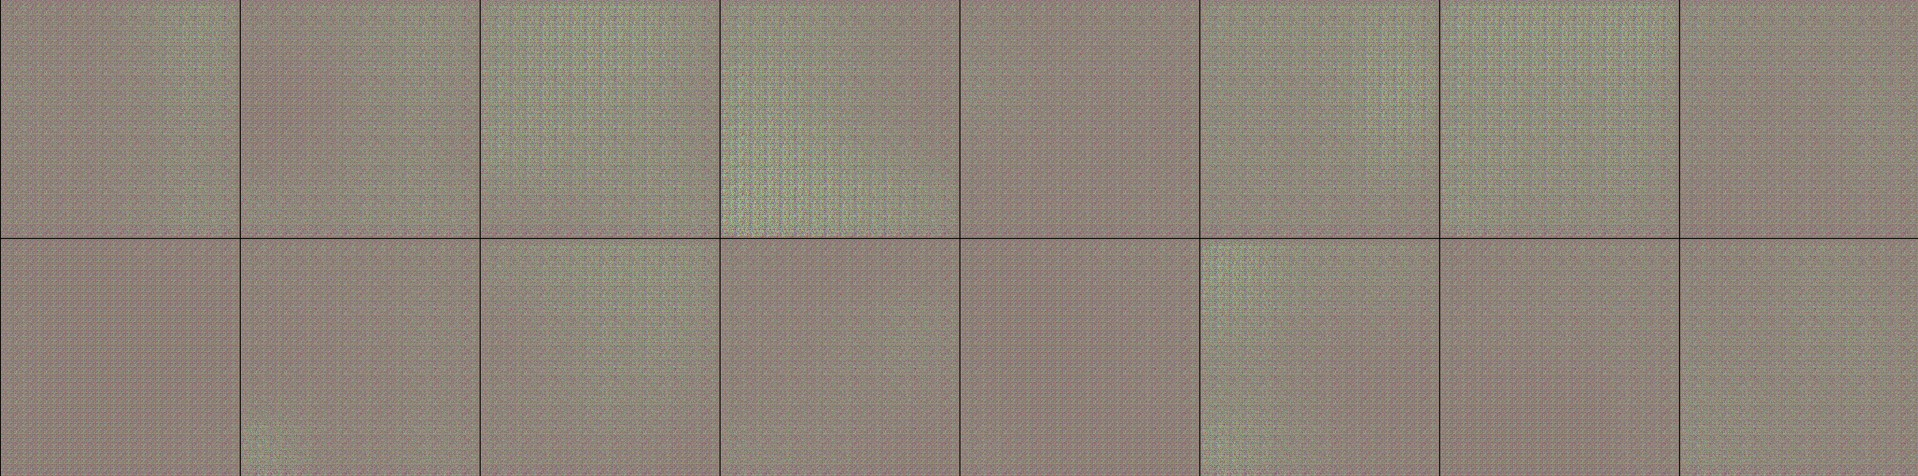

In [ ]:
Image('./generated/generated-images-0001.jpg')

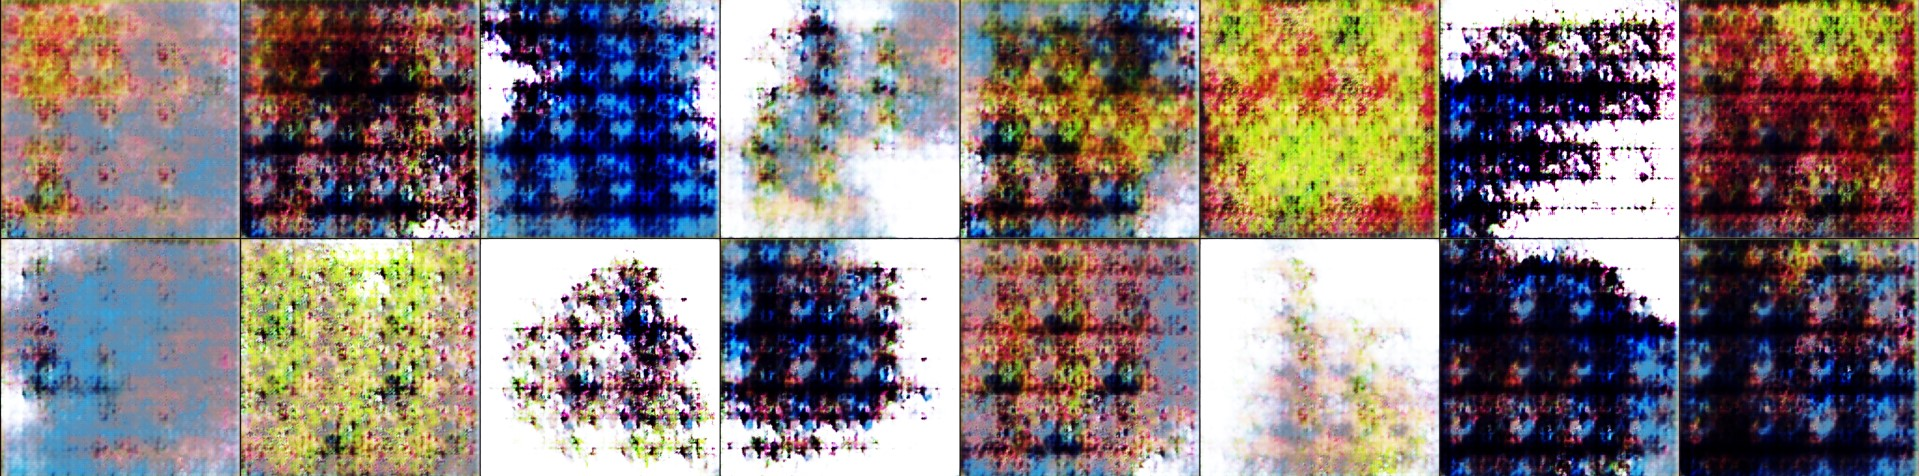

In [ ]:
Image('./generated/generated-images-0100.jpg')

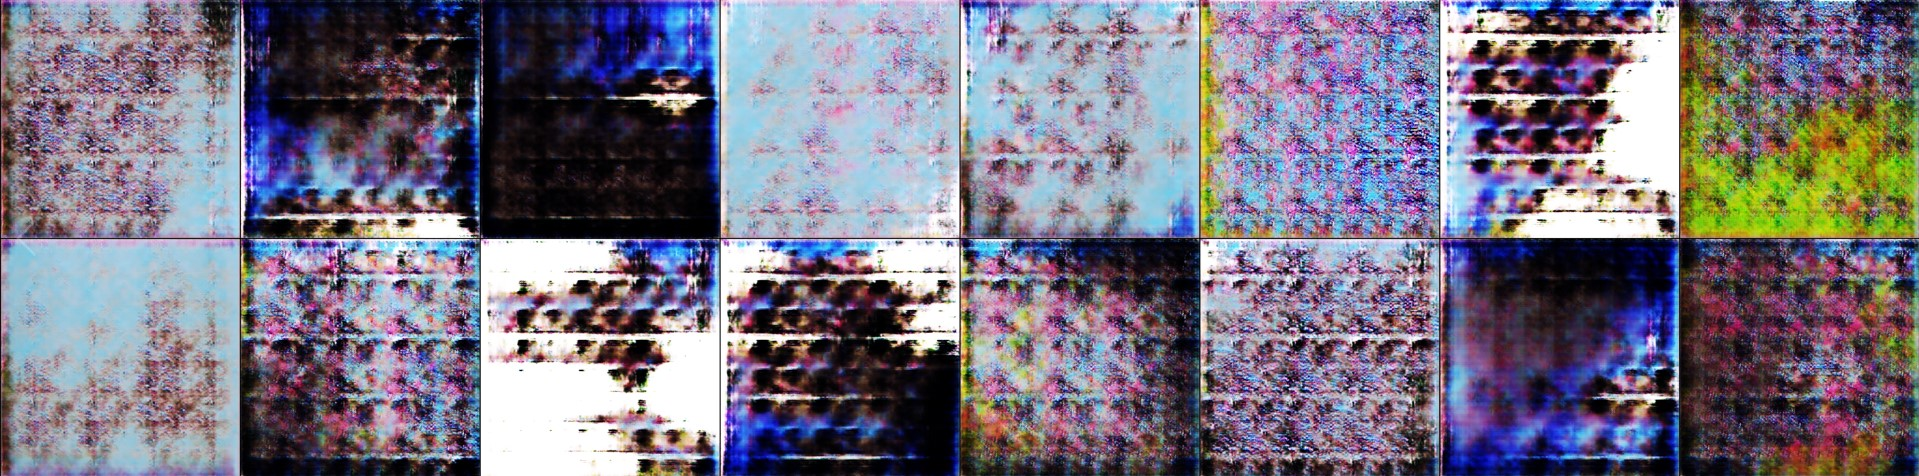

In [ ]:
Image('./generated/generated-images-0200.jpg')

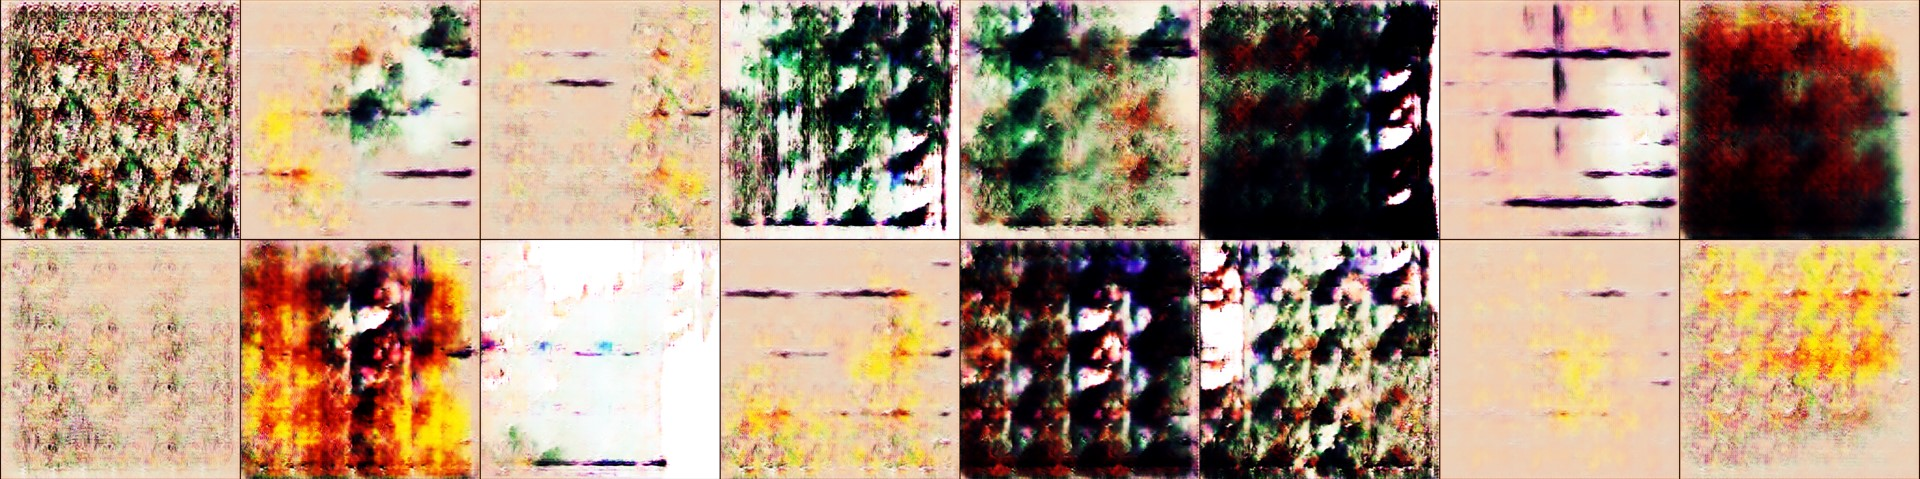

In [ ]:
Image('./generated/generated-images-0300.jpg')

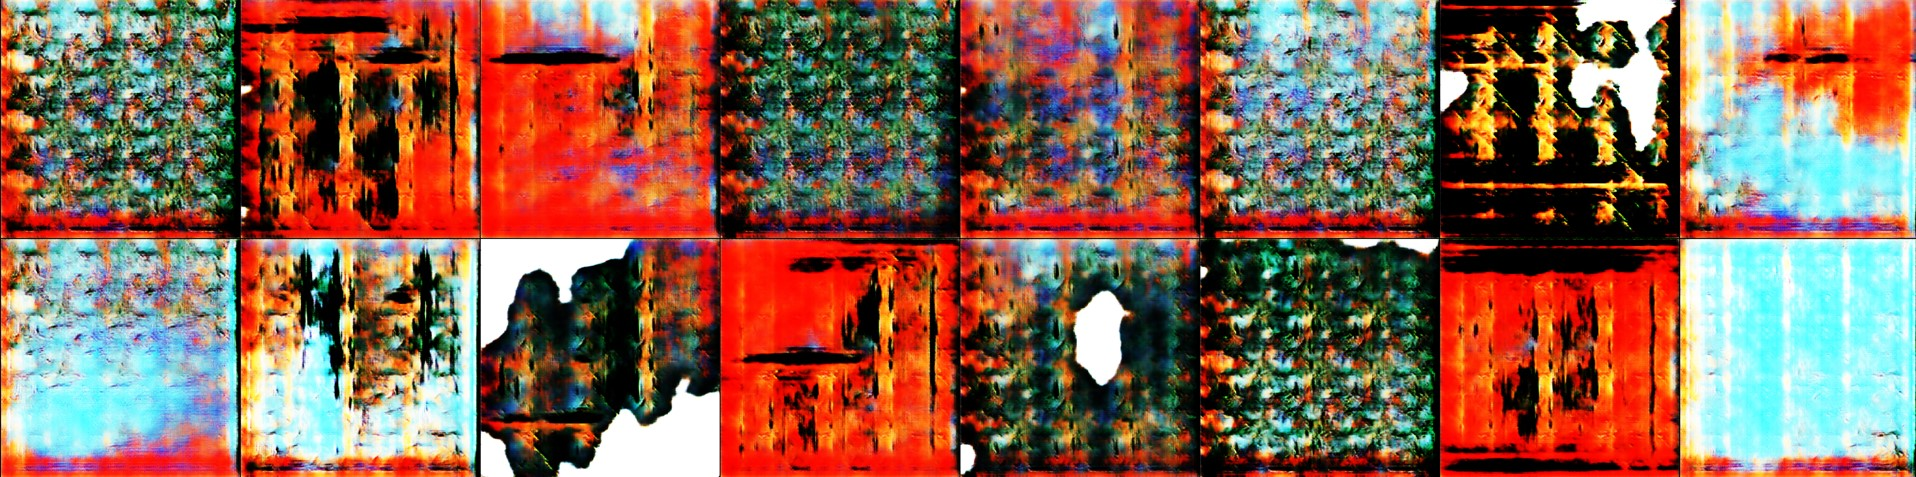

In [ ]:
Image('./generated/generated-images-0400.jpg')

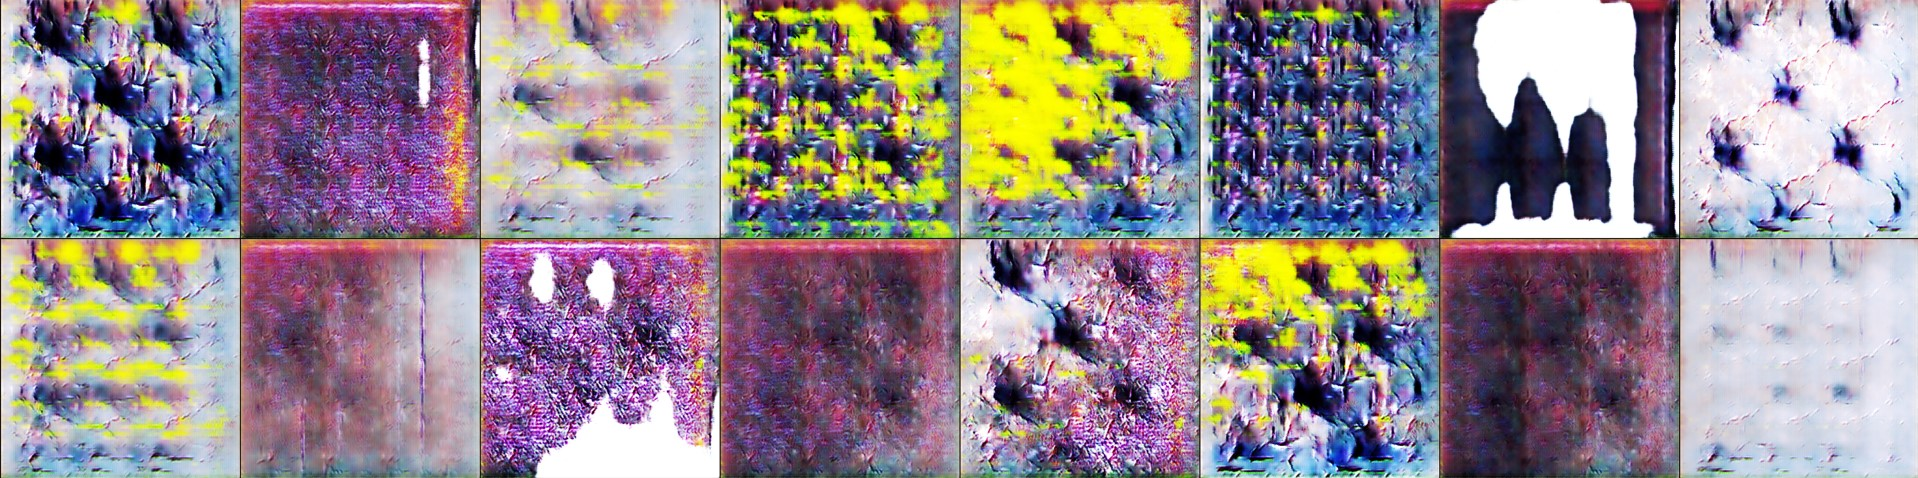

In [ ]:
Image('./generated/generated-images-0500.jpg')

**Plotting the Losses**

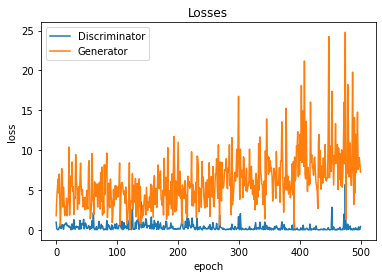

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

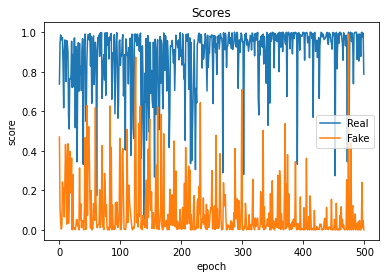

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## **Saving the Model**

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G_500.pth')
torch.save(discriminator.state_dict(), 'D_500.pth')